<a href="https://colab.research.google.com/github/IRPARKS/NMML/blob/main/NMML_PROJECT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rat08-20130711_017.h5

In [1]:
import h5py
import numpy as np

filepath = 'Rat08-20130711_017.h5'  # data file
f = h5py.File(filepath, 'r')  # read data with h5 format
fs = f.attrs['fs'][0]  # get sampling frequency of LFP signal (Hz)
print("Sampling rate: %.1f Hz" % (fs))

Sampling rate: 1250.0 Hz


In [2]:
states = []  # two states (NREM & WAKE) to be classified
# LFP recordings are store in two h5 groups for each state
# Under each h5 group, the LFP recordings are divided into several segments with different lengths.
for name, grp in f.items():
  states.append(name)
  print("State: %s" % (name))
  print("Segment IDs:")
  print(list(grp.keys()))

State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']


In [3]:
# Convert the recording in to numpy arrays
# Use a dictionary to store the LFP recordings of the two states
# each containing a list of numpy arrays of all segments
lfp = {key: [] for key in states}
for key in states:
  group = f[key]  # h5 group of a state
  n = len(group)  # number of segments
  for i in range(n):
    lfp[key].append(group[str(i+1)][()].astype(float))  # convert data to numpy array and from int type to float type

# print(lfp)

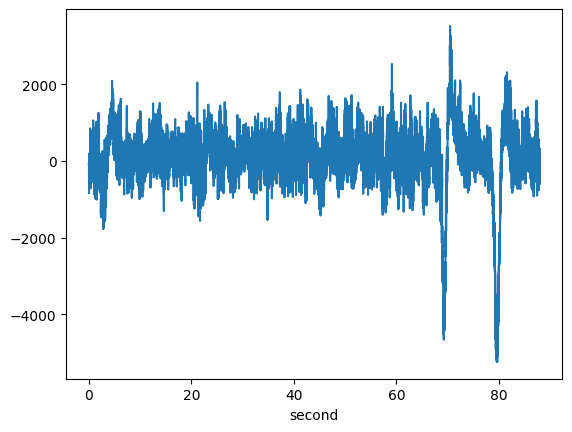

In [7]:
import matplotlib.pyplot as plt

x = lfp['NREM'][0]  # accessing the 10-th LFP segment in NREM state
t = np.arange(x.size)/fs  # time points

plt.plot(t,x)
plt.xlabel('second')
plt.show()

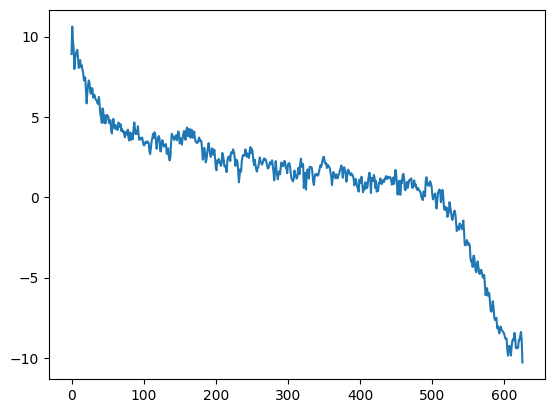

In [15]:
from scipy.signal import welch

f,pxx=welch(x[:int(5*fs)],fs=fs,nperseg=int(1*fs))
plt.plot(f,np.log(pxx))

In [16]:
import h5py
import numpy as np
import scipy.stats
import torch
import torch.nn as nn
from scipy.signal import welch
from sklearn.model_selection import train_test_split


In [17]:
def extract_features(signal, fs):
    # Calculate statistics of the signal clip
    mean_value = np.mean(signal)
    std_dev = np.std(signal)
    skewness = scipy.stats.skew(signal)
    kurtosis = scipy.stats.kurtosis(signal)

    # Calculate Power Spectral Density (PSD)
    f, pxx = welch(signal, fs=fs, nperseg=int(1*fs))

    # Normalize features (optional but recommended)
    features = [mean_value, std_dev, skewness, kurtosis]  # Add more features as needed
    features = (np.array(features) - np.mean(features)) / np.std(features)  # Z-score normalization

    return features


In [24]:
clip_length = 5  # Clip length in seconds (integer)
fs = 1250  # Assuming a default sampling frequency of 1250 Hz

X = []
y = []

for state in lfp:
    for segment in lfp[state]:
        segment_length = len(segment)
        clip_duration_samples = clip_length * fs

        for start in range(0, segment_length - clip_duration_samples, clip_duration_samples):
            clip = segment[start:start + clip_duration_samples]
            features = extract_features(clip, fs)
            X.append(features)
            y.append(0 if state == 'NREM' else 1)  # Use 0 for NREM and 1 for WAKE

X = np.array(X)
y = np.array(y)





In [25]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Define a simple fully connected neural network model using PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize model, criterion, optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_classes = 2
model = NeuralNetwork(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [26]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate model on validation set
with torch.no_grad():
    model.eval()
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item():.4f}')


Epoch [10/50], Loss: 0.6545
Epoch [20/50], Loss: 0.6335
Epoch [30/50], Loss: 0.6316
Epoch [40/50], Loss: 0.6317
Epoch [50/50], Loss: 0.6303
Validation Accuracy: 0.6357


In [ ]:
import numpy as np

# Define parameters
clip_length = 5  # Length of each clip in seconds
clip_length_samples = int(clip_length * fs)  # Convert clip length to samples

# Initialize lists to store clips and labels
clips = []
labels = []

# Iterate through each state
for state in lfp.keys():
    for segment in lfp[state]:
        # Calculate the number of clips in the segment
        num_clips = len(segment) // clip_length_samples

        # Cut the segment into smaller clips
        for i in range(num_clips):
            start_index = i * clip_length_samples
            end_index = start_index + clip_length_samples
            clip = segment[start_index:end_index]

            # Append the clip and its corresponding label to the lists
            clips.append(clip)
            labels.append(state)

# Convert lists to numpy arrays
clips = np.array(clips)
labels = np.array(labels)

# Print the shape of the resulting arrays
print("Shape of clips array:", clips.shape)
print("Shape of labels array:", labels.shape)


Shape of clips array: (3682, 6250)
Shape of labels array: (3682,)


In [ ]:
import scipy.stats

# Function to extract features from each clip
def extract_features(clip):
    # Calculate statistics
    stats = [np.mean(clip), np.std(clip), scipy.stats.skew(clip), scipy.stats.kurtosis(clip)]

    # Calculate PSD
    f, psd = scipy.signal.welch(clip, fs=fs, nperseg=clip_length_samples//10)  # Using a fraction of clip length for PSD
    psd_features = psd[:10]  # Taking low frequency resolution

    # Find oscillation frequency bands (e.g., delta, theta, alpha, beta)
    # Example: delta (0.5 - 4 Hz), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz)
    delta_band = np.where((f >= 0.5) & (f <= 4))[0]
    theta_band = np.where((f >= 4) & (f <= 8))[0]
    alpha_band = np.where((f >= 8) & (f <= 12))[0]
    beta_band = np.where((f >= 12) & (f <= 30))[0]

    # Bandpass filter the signal within each band
    delta_signal = np.mean(clip[delta_band])
    theta_signal = np.mean(clip[theta_band])
    alpha_signal = np.mean(clip[alpha_band])
    beta_signal = np.mean(clip[beta_band])

    # Perform normalization (e.g., z-score normalization)
    stats_normalized = (stats - np.mean(stats)) / np.std(stats)
    psd_normalized = (psd_features - np.mean(psd_features)) / np.std(psd_features)
    band_features_normalized = [delta_signal, theta_signal, alpha_signal, beta_signal]

    # Combine all features
    features = np.concatenate([stats_normalized, psd_normalized, band_features_normalized])

    return features

# Extract features for each clip
extracted_features = np.array([extract_features(clip) for clip in clips])

# Print the shape of the resulting features array
print("Shape of extracted features array:", extracted_features.shape)


Shape of extracted features array: (3682, 18)
